In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2


In [ ]:
# read the data
filepath_train = "/Users/tungvuduc/Desktop/PhD/projects/repos/notebooks/notebooks/assets/dna/datasets/CTCF_train_sequences.csv"
filepath_test = "/Users/tungvuduc/Desktop/PhD/projects/repos/notebooks/notebooks/assets/dna/datasets/CTCF_test_sequences.csv"

In [183]:
# lets encode the train_df numerically
# there are 4 different bases that make up the DNA: A-T-G-C

def dna_to_one_hot_encode(dna):
    base_to_one_hot = {
        "A": (1, 0 , 0, 0),
        "C": (0, 1 , 0, 0),
        "T": (0, 0 , 1, 0),
        "G": (0, 0 , 0, 1),
        "N": (1, 1, 1, 1) # unknown
    }
    return np.array([base_to_one_hot[base] for base in dna])

test_dna = "ATGAAT"

print(dna_to_one_hot_encode(test_dna))

[[1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]


In [184]:
# lets create a load_dataset function for simplicity

def load_dataset(path):
    loaded_ds = pd.read_csv(path)
    return {
        "labels": loaded_ds["label"].values,
        "sequences": [dna_to_one_hot_encode(sequence).T for sequence in loaded_ds["sequence"]]
        }

loaded_train_dataset = load_dataset(filepath_train)
loaded_test_dataset = load_dataset(filepath_test)

print(
    f"Labels are: {loaded_train_dataset["labels"][:0]}\n Sequences are: {loaded_train_dataset["sequences"][0].shape}"
)

Labels are: []
 Sequences are: (4, 200)


In [ ]:
# lets create a dataloader for better training the model
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

class DnaDataset(Dataset):
    def __init__(self, labels, sequences):

        self.labels = labels
        self.sequences = sequences

    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)

        return {
            "seq":sequence,
            "label":label
            }
    
    def __len__(self):
        return len(self.sequences)

dna_dataset_train = DnaDataset(
    labels=loaded_train_dataset["labels"],
    sequences=loaded_train_dataset["sequences"]
    )

dna_dataset_test = DnaDataset(
    labels=loaded_test_dataset["labels"],
    sequences=loaded_test_dataset["sequences"]
    )

# for different sequence lengths we need to pad the sequence to the same length for batching
# let's do it, for that we need a collate_fn

train_dataloader = DataLoader(dna_dataset_train, batch_size=65000, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(dna_dataset_test, batch_size=65000, shuffle=True, collate_fn=collate_fn)
# lets do some sanity checks
sample_train_batch = next(iter(train_dataloader))
print(f"Shape of first batch: {sample_train_batch["seq"].shape}")
print(f"Lengths batch: {sample_train_batch["lengths"]}")
print(f"Labels: {sample_train_batch["labels"]}")


Shape of first batch: torch.Size([61083, 4, 200])
Lengths batch: tensor([4, 4, 4,  ..., 4, 4, 4])
Labels: tensor([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])


In [214]:
import torch
import torch.nn as nn

class DNAConvNet(nn.Module):
    """
    Convolutional Neural Network for DNA sequence classification.
    
    Architecture:
    - 2 Conv1D blocks (Conv → GELU → MaxPool)
    - Flatten
    - 2 Fully connected layers with dropout
    - Sigmoid output for binary classification
    
    Args:
        in_channels (int): Number of input channels (4 for DNA: A, C, G, T)
        conv_channels (int): Number of output channels for conv layers
        kernel_size (int): Size of convolutional kernels
        dropout_rate (float): Dropout probability (default: 0.3)
    """
    def __init__(self, in_channels=4, conv_channels=64, kernel_size=10, dropout_rate=0.2):
        super().__init__()
        
        # Feature extraction with convolutional layers
        self.feature_extractor = nn.Sequential(
            # First conv block
            nn.Conv1d(in_channels=in_channels, out_channels=conv_channels, 
                     kernel_size=kernel_size, padding='same'),
            nn.BatchNorm1d(conv_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            # Second conv block
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, 
                     kernel_size=kernel_size, padding='same'),
            nn.BatchNorm1d(conv_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
        )
        
        # Flatten layer (cleaner than manual reshape)
        self.flatten = nn.Flatten()
        
        # Classification head (initialized dynamically in forward pass)
        self.classifier = None
        self.dropout_rate = dropout_rate
        
    def _init_classifier(self, flattened_size):
        """Initialize classifier layers based on flattened feature size."""
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, flattened_size // 2),
            nn.GELU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(flattened_size // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch_size, in_channels, seq_length)
            
        Returns:
            Output tensor of shape (batch_size, 1) with sigmoid probabilities
        """
        # Extract features
        x = self.feature_extractor(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Initialize classifier on first forward pass (lazy initialization)
        if self.classifier is None:
            self._init_classifier(x.shape[1])
            # Move classifier to same device as input
            self.classifier = self.classifier.to(x.device)
        
        # Classification
        x = self.classifier(x)
        
        return x

# Example usage
model = DNAConvNet(in_channels=4, conv_channels=64, kernel_size=3)

# Test with dummy data
dummy_input = torch.randn(32, 4, 100)  # batch=32, channels=4, length=100
output = model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Input shape: torch.Size([32, 4, 100])
Output shape: torch.Size([32, 1])
Total parameters: 1,295,041


In [215]:
# Hyperparameters
lr = 0.001
epochs = 200
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Initialize model, loss, optimizer
model = DNAConvNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Tracking
train_losses = []
val_losses = []
best_val_loss = float('inf')

Using device: mps


In [216]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        sequences = batch["seq"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            sequences = batch["seq"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [ ]:
# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, test_dataloader, criterion, device)
    
    if epoch % 10 == 0:
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_dna_model.pth')
        print("✓ Saved best model")

plt.plot(train_losses)
plt.plot(val_losses)



Epoch 1/200


Training:   0%|          | 0/1 [00:00<?, ?it/s]/Users/tungvuduc/opt/anaconda3/envs/dlbio_arm64/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1753838994289/work/aten/src/ATen/native/Convolution.cpp:1037.)
  return F.conv1d(
Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Train Loss: 0.6971 | Train Acc: 49.86%
Val Loss:   0.6926 | Val Acc:   52.85%
✓ Saved best model

Epoch 2/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Train Loss: 0.6873 | Train Acc: 54.35%
Val Loss:   0.6918 | Val Acc:   59.42%
✓ Saved best model

Epoch 3/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Train Loss: 0.6782 | Train Acc: 58.13%
Val Loss:   0.6909 | Val Acc:   63.69%
✓ Saved best model

Epoch 4/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Train Loss: 0.6707 | Train Acc: 60.85%
Val Loss:   0.6898 | Val Acc:   65.52%
✓ Saved best model

Epoch 5/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Train Loss: 0.6643 | Train Acc: 62.73%
Val Loss:   0.6885 | Val Acc:   66.06%
✓ Saved best model

Epoch 6/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Train Loss: 0.6600 | Train Acc: 63.96%
Val Loss:   0.6870 | Val Acc:   66.26%
✓ Saved best model

Epoch 7/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Train Loss: 0.6557 | Train Acc: 64.98%
Val Loss:   0.6852 | Val Acc:   66.57%
✓ Saved best model

Epoch 8/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Train Loss: 0.6529 | Train Acc: 65.56%
Val Loss:   0.6833 | Val Acc:   66.92%
✓ Saved best model

Epoch 9/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Train Loss: 0.6495 | Train Acc: 66.30%
Val Loss:   0.6812 | Val Acc:   67.19%
✓ Saved best model

Epoch 10/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Train Loss: 0.6476 | Train Acc: 66.79%
Val Loss:   0.6790 | Val Acc:   67.49%
✓ Saved best model

Epoch 11/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Train Loss: 0.6452 | Train Acc: 67.54%
Val Loss:   0.6768 | Val Acc:   68.03%
✓ Saved best model

Epoch 12/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Train Loss: 0.6438 | Train Acc: 67.80%
Val Loss:   0.6745 | Val Acc:   68.51%
✓ Saved best model

Epoch 13/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Train Loss: 0.6419 | Train Acc: 68.21%
Val Loss:   0.6723 | Val Acc:   68.97%
✓ Saved best model

Epoch 14/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Train Loss: 0.6400 | Train Acc: 68.60%
Val Loss:   0.6701 | Val Acc:   69.54%
✓ Saved best model

Epoch 15/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Train Loss: 0.6392 | Train Acc: 68.86%
Val Loss:   0.6679 | Val Acc:   70.09%
✓ Saved best model

Epoch 16/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Train Loss: 0.6373 | Train Acc: 69.08%
Val Loss:   0.6658 | Val Acc:   70.49%
✓ Saved best model

Epoch 17/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Train Loss: 0.6357 | Train Acc: 69.63%
Val Loss:   0.6637 | Val Acc:   70.80%
✓ Saved best model

Epoch 18/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Train Loss: 0.6350 | Train Acc: 69.84%
Val Loss:   0.6617 | Val Acc:   71.13%
✓ Saved best model

Epoch 19/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Train Loss: 0.6328 | Train Acc: 70.31%
Val Loss:   0.6598 | Val Acc:   71.52%
✓ Saved best model

Epoch 20/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.6319 | Train Acc: 70.32%
Val Loss:   0.6578 | Val Acc:   71.88%
✓ Saved best model

Epoch 21/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Train Loss: 0.6296 | Train Acc: 70.85%
Val Loss:   0.6559 | Val Acc:   72.19%
✓ Saved best model

Epoch 22/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Train Loss: 0.6278 | Train Acc: 71.34%
Val Loss:   0.6540 | Val Acc:   72.61%
✓ Saved best model

Epoch 23/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.6265 | Train Acc: 71.59%
Val Loss:   0.6522 | Val Acc:   72.92%
✓ Saved best model

Epoch 24/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Train Loss: 0.6246 | Train Acc: 71.78%
Val Loss:   0.6503 | Val Acc:   73.10%
✓ Saved best model

Epoch 25/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Train Loss: 0.6226 | Train Acc: 72.20%
Val Loss:   0.6484 | Val Acc:   73.51%
✓ Saved best model

Epoch 26/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Train Loss: 0.6211 | Train Acc: 72.48%
Val Loss:   0.6466 | Val Acc:   73.98%
✓ Saved best model

Epoch 27/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.6195 | Train Acc: 72.55%
Val Loss:   0.6447 | Val Acc:   74.32%
✓ Saved best model

Epoch 28/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.6174 | Train Acc: 72.87%
Val Loss:   0.6429 | Val Acc:   74.80%
✓ Saved best model

Epoch 29/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Train Loss: 0.6149 | Train Acc: 73.36%
Val Loss:   0.6410 | Val Acc:   75.31%
✓ Saved best model

Epoch 30/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Train Loss: 0.6135 | Train Acc: 73.88%
Val Loss:   0.6392 | Val Acc:   75.65%
✓ Saved best model

Epoch 31/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Train Loss: 0.6116 | Train Acc: 74.14%
Val Loss:   0.6373 | Val Acc:   76.11%
✓ Saved best model

Epoch 32/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Train Loss: 0.6094 | Train Acc: 74.59%
Val Loss:   0.6353 | Val Acc:   76.54%
✓ Saved best model

Epoch 33/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Train Loss: 0.6082 | Train Acc: 74.78%
Val Loss:   0.6333 | Val Acc:   77.00%
✓ Saved best model

Epoch 34/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Train Loss: 0.6052 | Train Acc: 75.39%
Val Loss:   0.6311 | Val Acc:   77.50%
✓ Saved best model

Epoch 35/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Train Loss: 0.6040 | Train Acc: 75.73%
Val Loss:   0.6288 | Val Acc:   77.90%
✓ Saved best model

Epoch 36/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.6019 | Train Acc: 76.09%
Val Loss:   0.6262 | Val Acc:   78.42%
✓ Saved best model

Epoch 37/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.6005 | Train Acc: 76.33%
Val Loss:   0.6234 | Val Acc:   78.77%
✓ Saved best model

Epoch 38/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Train Loss: 0.5981 | Train Acc: 76.61%
Val Loss:   0.6204 | Val Acc:   79.25%
✓ Saved best model

Epoch 39/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Train Loss: 0.5966 | Train Acc: 76.96%
Val Loss:   0.6173 | Val Acc:   79.64%
✓ Saved best model

Epoch 40/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Train Loss: 0.5949 | Train Acc: 77.16%
Val Loss:   0.6142 | Val Acc:   79.85%
✓ Saved best model

Epoch 41/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.5929 | Train Acc: 77.26%
Val Loss:   0.6112 | Val Acc:   80.17%
✓ Saved best model

Epoch 42/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Train Loss: 0.5911 | Train Acc: 77.38%
Val Loss:   0.6083 | Val Acc:   80.26%
✓ Saved best model

Epoch 43/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Train Loss: 0.5897 | Train Acc: 77.69%
Val Loss:   0.6058 | Val Acc:   80.34%
✓ Saved best model

Epoch 44/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.5884 | Train Acc: 77.75%
Val Loss:   0.6035 | Val Acc:   80.38%
✓ Saved best model

Epoch 45/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Train Loss: 0.5858 | Train Acc: 78.12%
Val Loss:   0.6016 | Val Acc:   80.48%
✓ Saved best model

Epoch 46/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.5841 | Train Acc: 78.32%
Val Loss:   0.5999 | Val Acc:   80.63%
✓ Saved best model

Epoch 47/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Train Loss: 0.5829 | Train Acc: 78.48%
Val Loss:   0.5984 | Val Acc:   80.78%
✓ Saved best model

Epoch 48/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.5806 | Train Acc: 79.03%
Val Loss:   0.5971 | Val Acc:   80.73%
✓ Saved best model

Epoch 49/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Train Loss: 0.5795 | Train Acc: 78.81%
Val Loss:   0.5957 | Val Acc:   80.83%
✓ Saved best model

Epoch 50/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Train Loss: 0.5776 | Train Acc: 79.19%
Val Loss:   0.5943 | Val Acc:   80.86%
✓ Saved best model

Epoch 51/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Train Loss: 0.5761 | Train Acc: 79.56%
Val Loss:   0.5927 | Val Acc:   80.92%
✓ Saved best model

Epoch 52/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Train Loss: 0.5745 | Train Acc: 79.65%
Val Loss:   0.5909 | Val Acc:   81.01%
✓ Saved best model

Epoch 53/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Train Loss: 0.5731 | Train Acc: 79.81%
Val Loss:   0.5888 | Val Acc:   81.11%
✓ Saved best model

Epoch 54/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Train Loss: 0.5718 | Train Acc: 79.86%
Val Loss:   0.5865 | Val Acc:   81.17%
✓ Saved best model

Epoch 55/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Train Loss: 0.5710 | Train Acc: 79.92%
Val Loss:   0.5841 | Val Acc:   81.25%
✓ Saved best model

Epoch 56/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Train Loss: 0.5686 | Train Acc: 80.20%
Val Loss:   0.5818 | Val Acc:   81.43%
✓ Saved best model

Epoch 57/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Train Loss: 0.5675 | Train Acc: 80.10%
Val Loss:   0.5796 | Val Acc:   81.56%
✓ Saved best model

Epoch 58/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Train Loss: 0.5660 | Train Acc: 80.41%
Val Loss:   0.5775 | Val Acc:   81.77%
✓ Saved best model

Epoch 59/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Train Loss: 0.5641 | Train Acc: 80.69%
Val Loss:   0.5756 | Val Acc:   81.97%
✓ Saved best model

Epoch 60/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Train Loss: 0.5634 | Train Acc: 80.80%
Val Loss:   0.5738 | Val Acc:   82.31%
✓ Saved best model

Epoch 61/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Train Loss: 0.5624 | Train Acc: 80.82%
Val Loss:   0.5720 | Val Acc:   82.54%
✓ Saved best model

Epoch 62/200


Validation: 100%|██████████| 1/1 [07:48<00:00, 468.08s/it]


Train Loss: 0.5607 | Train Acc: 81.06%
Val Loss:   0.5703 | Val Acc:   82.75%
✓ Saved best model

Epoch 63/200


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Train Loss: 0.5599 | Train Acc: 81.05%
Val Loss:   0.5684 | Val Acc:   82.94%
✓ Saved best model

Epoch 64/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Train Loss: 0.5580 | Train Acc: 81.25%
Val Loss:   0.5664 | Val Acc:   83.17%
✓ Saved best model

Epoch 65/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Train Loss: 0.5572 | Train Acc: 81.37%
Val Loss:   0.5644 | Val Acc:   83.29%
✓ Saved best model

Epoch 66/200


Validation: 100%|██████████| 1/1 [14:01<00:00, 841.49s/it]


Train Loss: 0.5561 | Train Acc: 81.49%
Val Loss:   0.5623 | Val Acc:   83.48%
✓ Saved best model

Epoch 67/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Train Loss: 0.5546 | Train Acc: 81.70%
Val Loss:   0.5602 | Val Acc:   83.74%
✓ Saved best model

Epoch 68/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Train Loss: 0.5541 | Train Acc: 81.40%
Val Loss:   0.5583 | Val Acc:   83.93%
✓ Saved best model

Epoch 69/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Train Loss: 0.5523 | Train Acc: 81.95%
Val Loss:   0.5564 | Val Acc:   84.04%
✓ Saved best model

Epoch 70/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Train Loss: 0.5508 | Train Acc: 81.91%
Val Loss:   0.5548 | Val Acc:   84.16%
✓ Saved best model

Epoch 71/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Train Loss: 0.5508 | Train Acc: 81.81%
Val Loss:   0.5533 | Val Acc:   84.37%
✓ Saved best model

Epoch 72/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Train Loss: 0.5493 | Train Acc: 82.08%
Val Loss:   0.5520 | Val Acc:   84.36%
✓ Saved best model

Epoch 73/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Train Loss: 0.5480 | Train Acc: 82.24%
Val Loss:   0.5508 | Val Acc:   84.39%
✓ Saved best model

Epoch 74/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Train Loss: 0.5472 | Train Acc: 82.18%
Val Loss:   0.5495 | Val Acc:   84.48%
✓ Saved best model

Epoch 75/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Train Loss: 0.5460 | Train Acc: 82.35%
Val Loss:   0.5483 | Val Acc:   84.50%
✓ Saved best model

Epoch 76/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Train Loss: 0.5447 | Train Acc: 82.35%
Val Loss:   0.5471 | Val Acc:   84.45%
✓ Saved best model

Epoch 77/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Train Loss: 0.5443 | Train Acc: 82.42%
Val Loss:   0.5460 | Val Acc:   84.64%
✓ Saved best model

Epoch 78/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Train Loss: 0.5424 | Train Acc: 82.59%
Val Loss:   0.5450 | Val Acc:   84.72%
✓ Saved best model

Epoch 79/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 0.5419 | Train Acc: 82.38%
Val Loss:   0.5441 | Val Acc:   84.74%
✓ Saved best model

Epoch 80/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Train Loss: 0.5409 | Train Acc: 82.47%
Val Loss:   0.5433 | Val Acc:   84.70%
✓ Saved best model

Epoch 81/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Train Loss: 0.5406 | Train Acc: 82.56%
Val Loss:   0.5426 | Val Acc:   84.74%
✓ Saved best model

Epoch 82/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Train Loss: 0.5387 | Train Acc: 82.90%
Val Loss:   0.5419 | Val Acc:   84.69%
✓ Saved best model

Epoch 83/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Train Loss: 0.5382 | Train Acc: 82.84%
Val Loss:   0.5412 | Val Acc:   84.75%
✓ Saved best model

Epoch 84/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Train Loss: 0.5373 | Train Acc: 82.81%
Val Loss:   0.5406 | Val Acc:   84.71%
✓ Saved best model

Epoch 85/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Train Loss: 0.5361 | Train Acc: 82.91%
Val Loss:   0.5399 | Val Acc:   84.80%
✓ Saved best model

Epoch 86/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Train Loss: 0.5352 | Train Acc: 82.91%
Val Loss:   0.5391 | Val Acc:   84.85%
✓ Saved best model

Epoch 87/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Train Loss: 0.5341 | Train Acc: 83.00%
Val Loss:   0.5384 | Val Acc:   84.83%
✓ Saved best model

Epoch 88/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Train Loss: 0.5340 | Train Acc: 82.88%
Val Loss:   0.5376 | Val Acc:   84.79%
✓ Saved best model

Epoch 89/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Train Loss: 0.5320 | Train Acc: 83.11%
Val Loss:   0.5370 | Val Acc:   84.80%
✓ Saved best model

Epoch 90/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Train Loss: 0.5308 | Train Acc: 83.18%
Val Loss:   0.5364 | Val Acc:   84.82%
✓ Saved best model

Epoch 91/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Train Loss: 0.5301 | Train Acc: 83.29%
Val Loss:   0.5357 | Val Acc:   84.90%
✓ Saved best model

Epoch 92/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.5288 | Train Acc: 83.49%
Val Loss:   0.5351 | Val Acc:   84.96%
✓ Saved best model

Epoch 93/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Train Loss: 0.5284 | Train Acc: 83.27%
Val Loss:   0.5344 | Val Acc:   85.03%
✓ Saved best model

Epoch 94/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Train Loss: 0.5267 | Train Acc: 83.56%
Val Loss:   0.5335 | Val Acc:   85.10%
✓ Saved best model

Epoch 95/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Train Loss: 0.5260 | Train Acc: 83.39%
Val Loss:   0.5327 | Val Acc:   85.13%
✓ Saved best model

Epoch 96/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Train Loss: 0.5250 | Train Acc: 83.54%
Val Loss:   0.5317 | Val Acc:   85.14%
✓ Saved best model

Epoch 97/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Train Loss: 0.5241 | Train Acc: 83.67%
Val Loss:   0.5308 | Val Acc:   85.27%
✓ Saved best model

Epoch 98/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Train Loss: 0.5232 | Train Acc: 83.48%
Val Loss:   0.5297 | Val Acc:   85.31%
✓ Saved best model

Epoch 99/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Train Loss: 0.5219 | Train Acc: 83.73%
Val Loss:   0.5288 | Val Acc:   85.46%
✓ Saved best model

Epoch 100/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Train Loss: 0.5207 | Train Acc: 83.80%
Val Loss:   0.5278 | Val Acc:   85.56%
✓ Saved best model

Epoch 101/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Train Loss: 0.5208 | Train Acc: 83.71%
Val Loss:   0.5268 | Val Acc:   85.54%
✓ Saved best model

Epoch 102/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Train Loss: 0.5192 | Train Acc: 83.88%
Val Loss:   0.5256 | Val Acc:   85.54%
✓ Saved best model

Epoch 103/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Train Loss: 0.5185 | Train Acc: 83.89%
Val Loss:   0.5244 | Val Acc:   85.56%
✓ Saved best model

Epoch 104/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Train Loss: 0.5178 | Train Acc: 83.90%
Val Loss:   0.5233 | Val Acc:   85.59%
✓ Saved best model

Epoch 105/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Train Loss: 0.5158 | Train Acc: 84.19%
Val Loss:   0.5223 | Val Acc:   85.65%
✓ Saved best model

Epoch 106/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Train Loss: 0.5157 | Train Acc: 83.98%
Val Loss:   0.5213 | Val Acc:   85.68%
✓ Saved best model

Epoch 107/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Train Loss: 0.5150 | Train Acc: 83.82%
Val Loss:   0.5202 | Val Acc:   85.73%
✓ Saved best model

Epoch 108/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Train Loss: 0.5141 | Train Acc: 84.01%
Val Loss:   0.5189 | Val Acc:   85.76%
✓ Saved best model

Epoch 109/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Train Loss: 0.5127 | Train Acc: 84.06%
Val Loss:   0.5176 | Val Acc:   85.77%
✓ Saved best model

Epoch 110/200


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Train Loss: 0.5120 | Train Acc: 84.08%
Val Loss:   0.5164 | Val Acc:   85.82%
✓ Saved best model

Epoch 111/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Train Loss: 0.5111 | Train Acc: 84.17%
Val Loss:   0.5152 | Val Acc:   85.87%
✓ Saved best model

Epoch 112/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Train Loss: 0.5096 | Train Acc: 84.15%
Val Loss:   0.5141 | Val Acc:   85.92%
✓ Saved best model

Epoch 113/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.5090 | Train Acc: 84.19%
Val Loss:   0.5130 | Val Acc:   86.00%
✓ Saved best model

Epoch 114/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Train Loss: 0.5086 | Train Acc: 84.17%
Val Loss:   0.5119 | Val Acc:   86.01%
✓ Saved best model

Epoch 115/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Train Loss: 0.5068 | Train Acc: 84.35%
Val Loss:   0.5106 | Val Acc:   86.09%
✓ Saved best model

Epoch 116/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Train Loss: 0.5061 | Train Acc: 84.29%
Val Loss:   0.5093 | Val Acc:   86.18%
✓ Saved best model

Epoch 117/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Train Loss: 0.5056 | Train Acc: 84.18%
Val Loss:   0.5081 | Val Acc:   86.17%
✓ Saved best model

Epoch 118/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Train Loss: 0.5041 | Train Acc: 84.49%
Val Loss:   0.5068 | Val Acc:   86.18%
✓ Saved best model

Epoch 119/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Train Loss: 0.5037 | Train Acc: 84.49%
Val Loss:   0.5056 | Val Acc:   86.22%
✓ Saved best model

Epoch 120/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.5024 | Train Acc: 84.53%
Val Loss:   0.5043 | Val Acc:   86.24%
✓ Saved best model

Epoch 121/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Train Loss: 0.5020 | Train Acc: 84.49%
Val Loss:   0.5031 | Val Acc:   86.30%
✓ Saved best model

Epoch 122/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.5008 | Train Acc: 84.65%
Val Loss:   0.5020 | Val Acc:   86.34%
✓ Saved best model

Epoch 123/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.5001 | Train Acc: 84.39%
Val Loss:   0.5009 | Val Acc:   86.40%
✓ Saved best model

Epoch 124/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Train Loss: 0.5000 | Train Acc: 84.36%
Val Loss:   0.4998 | Val Acc:   86.46%
✓ Saved best model

Epoch 125/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Train Loss: 0.4983 | Train Acc: 84.56%
Val Loss:   0.4988 | Val Acc:   86.48%
✓ Saved best model

Epoch 126/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Train Loss: 0.4966 | Train Acc: 84.72%
Val Loss:   0.4979 | Val Acc:   86.44%
✓ Saved best model

Epoch 127/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Train Loss: 0.4969 | Train Acc: 84.74%
Val Loss:   0.4970 | Val Acc:   86.47%
✓ Saved best model

Epoch 128/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.4952 | Train Acc: 84.68%
Val Loss:   0.4961 | Val Acc:   86.50%
✓ Saved best model

Epoch 129/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Train Loss: 0.4948 | Train Acc: 84.66%
Val Loss:   0.4951 | Val Acc:   86.54%
✓ Saved best model

Epoch 130/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.4938 | Train Acc: 84.83%
Val Loss:   0.4940 | Val Acc:   86.53%
✓ Saved best model

Epoch 131/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.4925 | Train Acc: 84.89%
Val Loss:   0.4931 | Val Acc:   86.59%
✓ Saved best model

Epoch 132/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.4928 | Train Acc: 84.85%
Val Loss:   0.4923 | Val Acc:   86.62%
✓ Saved best model

Epoch 133/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Train Loss: 0.4918 | Train Acc: 84.86%
Val Loss:   0.4914 | Val Acc:   86.66%
✓ Saved best model

Epoch 134/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Train Loss: 0.4909 | Train Acc: 84.86%
Val Loss:   0.4904 | Val Acc:   86.67%
✓ Saved best model

Epoch 135/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Train Loss: 0.4899 | Train Acc: 84.96%
Val Loss:   0.4895 | Val Acc:   86.64%
✓ Saved best model

Epoch 136/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Train Loss: 0.4894 | Train Acc: 85.01%
Val Loss:   0.4886 | Val Acc:   86.70%
✓ Saved best model

Epoch 137/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Train Loss: 0.4881 | Train Acc: 85.09%
Val Loss:   0.4878 | Val Acc:   86.76%
✓ Saved best model

Epoch 138/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.4879 | Train Acc: 85.07%
Val Loss:   0.4871 | Val Acc:   86.84%
✓ Saved best model

Epoch 139/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.4868 | Train Acc: 85.17%
Val Loss:   0.4863 | Val Acc:   86.86%
✓ Saved best model

Epoch 140/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Train Loss: 0.4856 | Train Acc: 85.33%
Val Loss:   0.4854 | Val Acc:   86.89%
✓ Saved best model

Epoch 141/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Train Loss: 0.4853 | Train Acc: 84.99%
Val Loss:   0.4845 | Val Acc:   86.86%
✓ Saved best model

Epoch 142/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Train Loss: 0.4843 | Train Acc: 85.23%
Val Loss:   0.4837 | Val Acc:   86.83%
✓ Saved best model

Epoch 143/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Train Loss: 0.4842 | Train Acc: 85.03%
Val Loss:   0.4830 | Val Acc:   86.87%
✓ Saved best model

Epoch 144/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.4827 | Train Acc: 85.47%
Val Loss:   0.4823 | Val Acc:   86.93%
✓ Saved best model

Epoch 145/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.4825 | Train Acc: 85.27%
Val Loss:   0.4813 | Val Acc:   86.94%
✓ Saved best model

Epoch 146/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Train Loss: 0.4816 | Train Acc: 85.38%
Val Loss:   0.4802 | Val Acc:   86.92%
✓ Saved best model

Epoch 147/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.4821 | Train Acc: 85.18%
Val Loss:   0.4791 | Val Acc:   86.92%
✓ Saved best model

Epoch 148/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Train Loss: 0.4800 | Train Acc: 85.41%
Val Loss:   0.4783 | Val Acc:   86.95%
✓ Saved best model

Epoch 149/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Train Loss: 0.4798 | Train Acc: 85.40%
Val Loss:   0.4774 | Val Acc:   86.95%
✓ Saved best model

Epoch 150/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.4788 | Train Acc: 85.37%
Val Loss:   0.4765 | Val Acc:   87.05%
✓ Saved best model

Epoch 151/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Train Loss: 0.4780 | Train Acc: 85.60%
Val Loss:   0.4756 | Val Acc:   87.05%
✓ Saved best model

Epoch 152/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Train Loss: 0.4772 | Train Acc: 85.39%
Val Loss:   0.4747 | Val Acc:   87.10%
✓ Saved best model

Epoch 153/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Train Loss: 0.4772 | Train Acc: 85.41%
Val Loss:   0.4737 | Val Acc:   87.10%
✓ Saved best model

Epoch 154/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Train Loss: 0.4766 | Train Acc: 85.49%
Val Loss:   0.4731 | Val Acc:   87.11%
✓ Saved best model

Epoch 155/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Train Loss: 0.4754 | Train Acc: 85.58%
Val Loss:   0.4725 | Val Acc:   87.22%
✓ Saved best model

Epoch 156/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Train Loss: 0.4748 | Train Acc: 85.80%
Val Loss:   0.4717 | Val Acc:   87.23%
✓ Saved best model

Epoch 157/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Train Loss: 0.4746 | Train Acc: 85.62%
Val Loss:   0.4706 | Val Acc:   87.22%
✓ Saved best model

Epoch 158/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Train Loss: 0.4737 | Train Acc: 85.54%
Val Loss:   0.4698 | Val Acc:   87.22%
✓ Saved best model

Epoch 159/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Train Loss: 0.4739 | Train Acc: 85.72%
Val Loss:   0.4692 | Val Acc:   87.23%
✓ Saved best model

Epoch 160/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Train Loss: 0.4718 | Train Acc: 85.76%
Val Loss:   0.4686 | Val Acc:   87.33%
✓ Saved best model

Epoch 161/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Train Loss: 0.4722 | Train Acc: 85.63%
Val Loss:   0.4678 | Val Acc:   87.31%
✓ Saved best model

Epoch 162/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Train Loss: 0.4709 | Train Acc: 85.78%
Val Loss:   0.4669 | Val Acc:   87.31%
✓ Saved best model

Epoch 163/200


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Train Loss: 0.4707 | Train Acc: 85.69%
Val Loss:   0.4660 | Val Acc:   87.34%
✓ Saved best model

Epoch 164/200


Training:   0%|          | 0/1 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [192]:
# now let's do some model interpretation
# How do we do this? We change the input and see how this changes the output, that simple
# By changing each base positions encoding we can see what the most important parts of the
# DNA is for TF binding -> Let's do it! (:

def generate_all_mutations(sequence):
    mutated_sequences_collection = []
    for i in range(sequence.shape[1]):
        for j in range(4): # because we have 4 bases
            mutated_sequence = sequence.copy()
            mutated_sequence[:, i] = np.zeros(4)
            mutated_sequence[j, i] = 1
            mutated_sequences_collection.append(mutated_sequence)
    
    mutated_sequences_collection = np.stack(mutated_sequences_collection)
    return torch.tensor(mutated_sequences_collection, dtype=torch.float32)

sample_index = np.argmax([*iter(test_dataloader)][0]["labels"])
sample = [*iter(test_dataloader)][0]["seq"][sample_index]

mutated_sequences = generate_all_mutations(sample.numpy())

<Axes: >

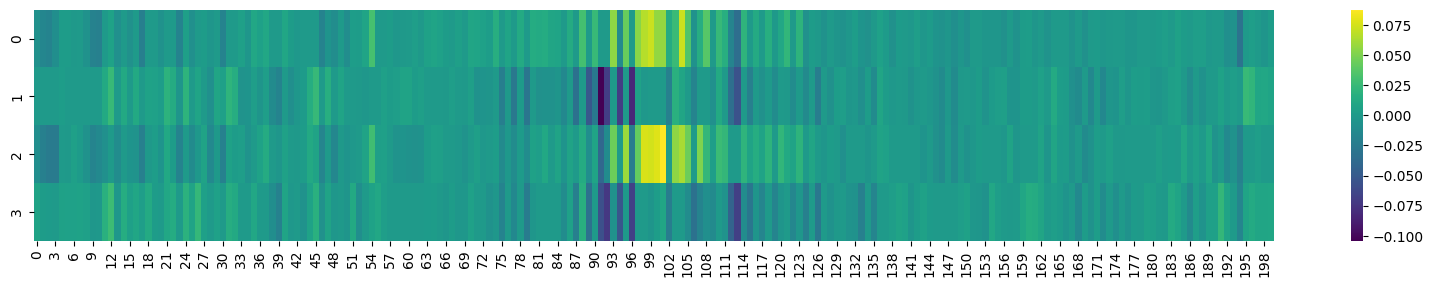

In [193]:
muta_output = model(mutated_sequences.to(device))
muta_output = muta_output.reshape(200, 4).detach().to("cpu").numpy().T
output = model(sample.unsqueeze(0).to(device))
output = output.detach().to("cpu").numpy().T

diff = output - muta_output
plt.figure(figsize=(20, 3))
sns.heatmap(diff, cmap="viridis")

<Axes: >

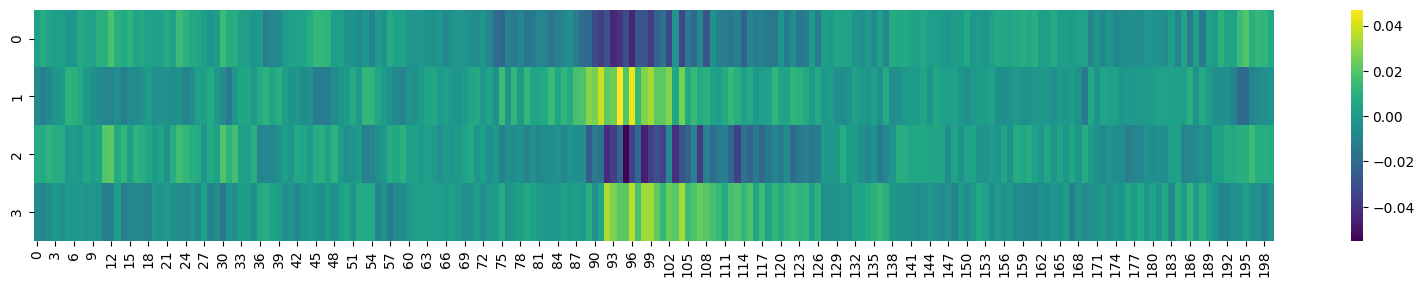

In [213]:
# another way to for model interpretation is by computing the gradient

def compute_gradient(model, sequence, device):

    model.eval()

    if sequence.ndim == 2:
        sequence = sequence.unsqueeze(0)
    sequence = sequence.to(device).requires_grad_(True)
    output = model(sequence)
    output.backward()
    gradients = sequence.grad.to("cpu")

    return gradients.squeeze(0)

grads = compute_gradient(model, sample, device)

plt.figure(figsize=(20, 3))
sns.heatmap(grads.numpy(), cmap="viridis")